# Fine-tuning BERT to generate word embeddings

In [ ]:
import os

# Create the directory if it doesn't exist:
scratch_cache = "/ocean/projects/mth250011p/smazioud/huggingface_cache"
os.makedirs(scratch_cache, exist_ok=True)

# Force HuggingFace + PyTorch to store EVERYTHING there
os.environ['HF_HOME'] = scratch_cache
os.environ['TRANSFORMERS_CACHE'] = scratch_cache
os.environ['HF_DATASETS_CACHE'] = scratch_cache
os.environ['HF_MODULES_CACHE'] = scratch_cache
os.environ['HF_METRICS_CACHE'] = scratch_cache
os.environ['TORCH_HOME'] = scratch_cache
# os.environ["HF_HUB_OFFLINE"] = "1"
# os.environ["TRANSFORMERS_OFFLINE"] = "1"

from huggingface_hub import login
login() # add your token here

print("HF cache directory:", scratch_cache)

/jet/home/smazioud/.conda/envs/env_215a/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HF cache directory: /ocean/projects/mth250011p/smazioud/huggingface_cache


In [2]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import h5py   

import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForMaskedLM, BertModel
from datasets import Dataset
from fine_tune_bert import mask_tokens, train_bert, apply_lora_to_bert
from data_cleaning import clean_data

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


/jet/home/smazioud/.conda/envs/env_215a/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cpu


In [ ]:
repo_root = "/jet/home/smazioud/stat215a_final"
sys.path.append(repo_root)

raw_path = "/ocean/projects/mth250011p/shared/215a/final_project/data/raw_text.pkl"

with open(raw_path, "rb") as f:
    raw = pickle.load(f)

story_texts, story_ids = clean_data(raw)
print(f"\nNumber of stories: {len(story_texts)}")
print(f"Example story ID: {story_ids[0]}")
print(f"Example text (first 200 chars):\n{story_texts[0][:200]}\n")




Number of stories: 109
Example story ID: sweetaspie
Example text (first 200 chars):
 i embarked on a journey toward the sea of matrimony at the perilous age of forty one yeah you'd think forty one a trip to marriage would be pretty smooth but nobody had told my family my sister calle



: 

: 

### Load tokenizer

In [6]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
print(f"Tokenizer loaded: {model_name}")

Tokenizer loaded: bert-base-uncased


/jet/home/smazioud/.conda/envs/env_215a/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Tokenize dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

max_seq_len = 128  # fixed window length for BERT

# 3) Tokenize and chunk stories
story_chunks = []

for text in story_texts:
    token_ids = tokenizer(
        text,
        add_special_tokens=False,
        return_attention_mask=False,
        return_tensors=None,
    )["input_ids"]

    story_input_ids = []
    story_attn = []

    for i in range(0, len(token_ids), max_seq_len):
        chunk = token_ids[i:i + max_seq_len]

        padded = tokenizer.pad(
            {"input_ids": [chunk]},
            padding="max_length",
            max_length=max_seq_len,
            return_attention_mask=True,
            return_tensors="pt",
        )

        story_input_ids.append(padded["input_ids"][0])
        story_attn.append(padded["attention_mask"][0])

    story_chunks.append((
        torch.stack(story_input_ids),
        torch.stack(story_attn)
    ))


# # 4) Stack into tensors
# input_ids = torch.stack(all_input_ids)         # (num_chunks, max_seq_len)
# attention_mask = torch.stack(all_attention_masks)

# print("Number of chunks:", input_ids.shape[0])
# print("Sequence length:", input_ids.shape[1])


Token indices sequence length is longer than the specified maximum sequence length for this model (810 > 512). Running this sequence through the model will result in indexing errors
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
class TextDataset(Dataset):
    def __init__(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        assert input_ids.shape == attention_mask.shape
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
        }

def flatten_story_chunks(stories):
    X = []
    A = []
    for ids, attn in stories:
        X.append(ids)
        A.append(attn)
    return torch.vstack(X), torch.vstack(A)



# Simple train/val split
val_frac = 0.2
n_stories = len(story_chunks)
n_val_stories = max(1, int(val_frac * n_stories))

train_stories = story_chunks[:-n_val_stories]
val_stories   = story_chunks[-n_val_stories:]

train_stories = story_chunks[:-n_val_stories]
val_stories   = story_chunks[-n_val_stories:]

train_ids, train_mask = flatten_story_chunks(train_stories)
val_ids,   val_mask   = flatten_story_chunks(val_stories)

train_dataset = TextDataset(train_ids, train_mask)
val_dataset   = TextDataset(val_ids, val_mask)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 93, Val batches: 21


## Fine-tune

In [ ]:
# Load BERT, apply LORA

from transformers import BertForMaskedLM

base_model = BertForMaskedLM.from_pretrained(model_name)
base_model = base_model.to(DEVICE)

print(f"Base model parameters: {sum(p.numel() for p in base_model.parameters()):,}")

# Wrap with LoRA adapters
lora_model = apply_lora_to_bert(base_model, r=8, alpha=16, dropout=0.1)
lora_model = lora_model.to(DEVICE)

print(f"LoRA-wrapped model is on device: {DEVICE}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Base model parameters: 109,514,298
trainable params: 1,339,392 || all params: 110,853,690 || trainable%: 1.208252066304694
LoRA-wrapped model is on device: cuda


In [ ]:
epochs = 5
lr = 5e-5

trained_model = train_bert(
    model=lora_model,
    train_loader=train_loader,
    tokenizer=tokenizer,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    device=DEVICE,
)

output_dir = Path(repo_root) / "saved_models" / "bert_lora_finetuned"
output_dir.mkdir(parents=True, exist_ok=True)

trained_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Fine-tuned LoRA model saved to: {output_dir}")

Epoch 1/5: 100%|██████████| 93/93 [00:11<00:00,  7.99it/s, loss=3.19]


Epoch 1 train loss: 3.1541
Epoch 1 val loss: 2.6993


Epoch 2/5: 100%|██████████| 93/93 [00:11<00:00,  8.28it/s, loss=2.79]


Epoch 2 train loss: 2.8130
Epoch 2 val loss: 2.5679


Epoch 3/5: 100%|██████████| 93/93 [00:11<00:00,  8.24it/s, loss=2.73]


Epoch 3 train loss: 2.7189
Epoch 3 val loss: 2.5600


Epoch 4/5: 100%|██████████| 93/93 [00:11<00:00,  8.28it/s, loss=2.74]


Epoch 4 train loss: 2.6639
Epoch 4 val loss: 2.5555


Epoch 5/5: 100%|██████████| 93/93 [00:11<00:00,  8.29it/s, loss=1.97]


Epoch 5 train loss: 2.6355
Epoch 5 val loss: 2.5434
Training complete.
Fine-tuned LoRA model saved to: /jet/home/smazioud/stat215a_final/saved_models/bert_lora_finetuned


/jet/home/smazioud/.conda/envs/env_215a/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Embeddings

In [ ]:
from transformers import BertModel

output_dir = Path(repo_root) / "saved_models" / "bert_lora_finetuned"
finetuned_bert = BertModel.from_pretrained(output_dir, output_hidden_states=True)
finetuned_bert = finetuned_bert.to(DEVICE)
finetuned_bert.eval()

print("Loaded finetuned encoder for embeddings.")

Loading adapter weights from /jet/home/smazioud/stat215a_final/saved_models/bert_lora_finetuned led to unexpected keys not found in the model:  ['bert.encoder.layer.0.attention.output.dense.lora_A.default.weight', 'bert.encoder.layer.0.attention.output.dense.lora_B.default.weight', 'bert.encoder.layer.0.attention.self.key.lora_A.default.weight', 'bert.encoder.layer.0.attention.self.key.lora_B.default.weight', 'bert.encoder.layer.0.attention.self.query.lora_A.default.weight', 'bert.encoder.layer.0.attention.self.query.lora_B.default.weight', 'bert.encoder.layer.0.attention.self.value.lora_A.default.weight', 'bert.encoder.layer.0.attention.self.value.lora_B.default.weight', 'bert.encoder.layer.0.intermediate.dense.lora_A.default.weight', 'bert.encoder.layer.0.intermediate.dense.lora_B.default.weight', 'bert.encoder.layer.0.output.dense.lora_A.default.weight', 'bert.encoder.layer.0.output.dense.lora_B.default.weight', 'bert.encoder.layer.1.attention.output.dense.lora_A.default.weight', 'b

Loaded finetuned encoder for embeddings.


In [ ]:
def get_bert_word_embeddings_for_words(
    words,
    tokenizer,
    model: BertModel,
    device=DEVICE,
    chunk_size: int = 256,
):
    """
    Compute word-level embeddings for a list of words using BERT.

    - Tokenize with is_split_into_words=True
    - Average subword token embeddings per word
    """
    model.eval()
    hidden_dim = model.config.hidden_size
    T = len(words)
    embs = np.zeros((T, hidden_dim), dtype=np.float32)

    start = 0
    with torch.no_grad():
        while start < T:
            end = min(start + chunk_size, T)
            chunk_words = words[start:end]

            enc = tokenizer(
                chunk_words,
                is_split_into_words=True,
                return_tensors="pt",
                padding=True,
                truncation=True,
            ).to(device)

            outputs = model(**enc)
            last_hidden = outputs.last_hidden_state.cpu()  # (1, L, H)

            # Map tokens back to original word indices
            word_ids = enc.word_ids(batch_index=0)
            word_to_vecs = {}

            for tok_idx, w_id in enumerate(word_ids):
                if w_id is None:
                    continue
                word_to_vecs.setdefault(w_id, []).append(last_hidden[0, tok_idx].numpy())

            # Average subword embeddings per word
            for local_w_id, vecs in word_to_vecs.items():
                global_w_id = start + local_w_id
                if global_w_id < T:
                    embs[global_w_id] = np.mean(vecs, axis=0)

            start = end

    return embs


In [ ]:
bert_embeddings = {}  # story_id -> dict

output_dir = Path(repo_root) / "embeddings" / "bert_lora_finetuned"

for story_id, ds in raw.items():
    words = ds.data               # list[str]
    word_times = ds.data_times    # np.array, shape (T,)
    tr_times = ds.tr_times        # np.array, shape (n_TR,)

    print(f"Processing story: {story_id}, #words = {len(words)}")

    embs = get_bert_word_embeddings_for_words(
        words=words,
        tokenizer=tokenizer,
        model=finetuned_bert,
        device=DEVICE,
        chunk_size=256
    )  # shape (T, 768)

    print("  embeddings shape:", embs.shape)

    bert_embeddings[story_id] = {
        "words": words,
        "word_times": word_times,
        "tr_times": tr_times,
        "embeddings": embs,
    }

out_path = output_dir / "bert_lora_finetuned_word_embeddings.pkl"

with open(out_path, "wb") as f:
    pickle.dump(bert_embeddings, f)

Processing story: sweetaspie, #words = 697
  embeddings shape: (697, 768)
Processing story: thatthingonmyarm, #words = 2073
  embeddings shape: (2073, 768)
Processing story: tildeath, #words = 2297
  embeddings shape: (2297, 768)
Processing story: indianapolis, #words = 1554
  embeddings shape: (1554, 768)
Processing story: lawsthatchokecreativity, #words = 2084
  embeddings shape: (2084, 768)
Processing story: golfclubbing, #words = 1211
  embeddings shape: (1211, 768)
Processing story: jugglingandjesus, #words = 887
  embeddings shape: (887, 768)
Processing story: shoppinginchina, #words = 1731
  embeddings shape: (1731, 768)
Processing story: cocoonoflove, #words = 1984
  embeddings shape: (1984, 768)
Processing story: hangtime, #words = 1927
  embeddings shape: (1927, 768)
Processing story: beneaththemushroomcloud, #words = 1916
  embeddings shape: (1916, 768)
Processing story: dialogue4, #words = 1692
  embeddings shape: (1692, 768)
Processing story: thepostmanalwayscalls, #words 

## Visualizations

### PCA

adventuresinsayingyes (2309, 768)


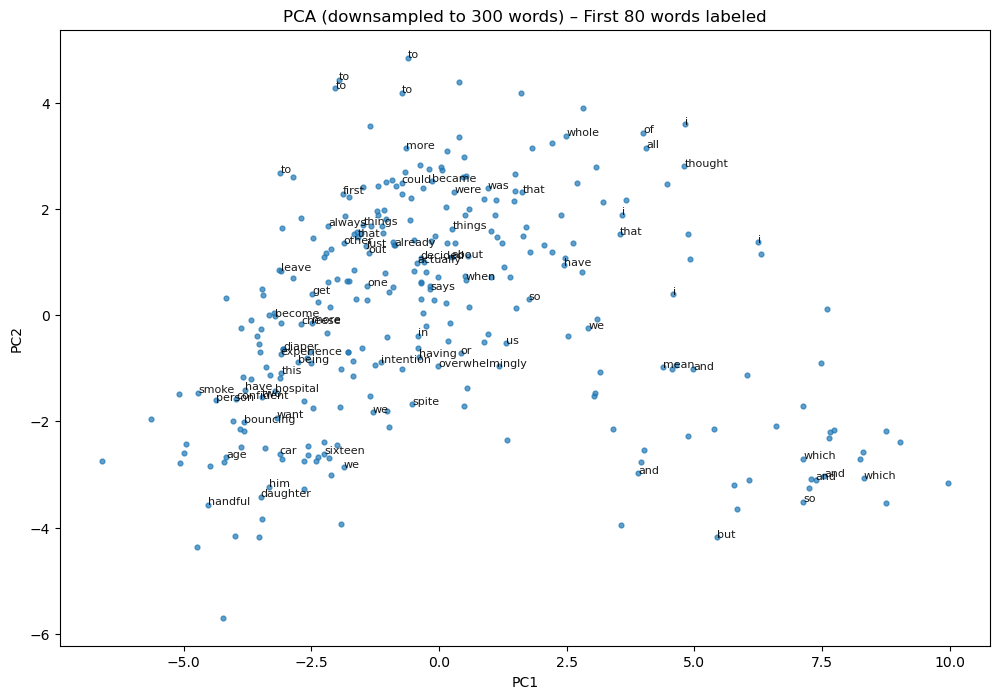

In [ ]:
emb_path = Path(output_dir) / "bert_lora_finetuned_word_embeddings.pkl"

with open(emb_path, "rb") as f:
    bert_embeddings = pickle.load(f)

first_sid = sorted(bert_embeddings.keys())[1]
story_data = bert_embeddings[first_sid]

embs = story_data["embeddings"]   # shape (T, 768)
words = story_data["words"]       # list of T words
print(first_sid, embs.shape)

T = embs.shape[0]   # total number of word-level embeddings

if T <= 300:
    idx = np.arange(T)
else:
    idx = np.linspace(0, T-1, 300, dtype=int)

embs_ds = embs[idx]          # (300, 768)
words_ds = [words[i] for i in idx]


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embs_pca = pca.fit_transform(embs_ds)

plt.figure(figsize=(12, 8))
plt.scatter(embs_pca[:, 0], embs_pca[:, 1], s=12, alpha=0.7)

# Label first 80 words
num_labels = min(80, len(words_ds))
for i in range(num_labels):
    plt.text(
        embs_pca[i, 0],
        embs_pca[i, 1],
        words_ds[i],
        fontsize=8,
        color="black",
        alpha=0.9
    )

plt.title("PCA (downsampled to 300 words) – First 80 words labeled")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



### t-SNE

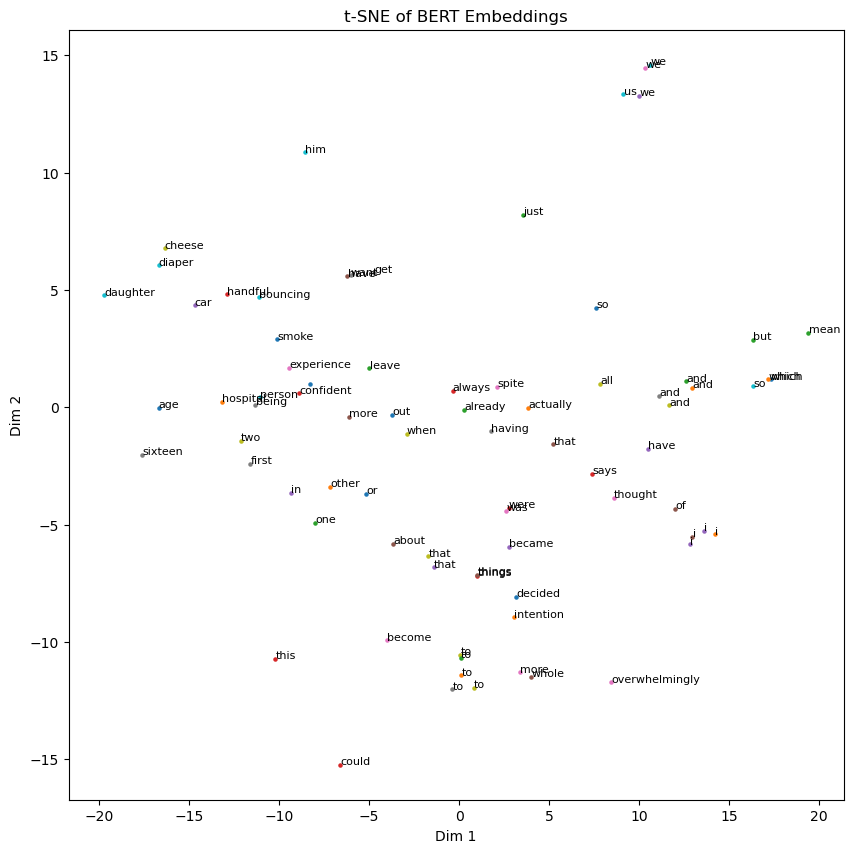

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,        # good for 200 < n < 2000
    learning_rate=200, 
    init='pca',           # MUCH better results
    random_state=42,
    n_jobs=-1             # parallel threads (sklearn >=1.4)
)

emb2d_tsne = tsne.fit_transform(embs_ds)

plt.figure(figsize=(10,10))
for i, w in enumerate(words_ds[:80]):  # label first 80 to avoid clutter
    x, y = emb2d_tsne[i]
    plt.scatter(x, y, s=5)
    plt.text(x + 0.01, y + 0.01, w, fontsize=8)
plt.title("t-SNE of BERT Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


## Pre-processing

In [7]:
from preprocessing import downsample_word_vectors, make_delayed

BASE_DIR = Path("/ocean/projects/mth250011p/shared/215a/final_project")
TEXT_PATH = BASE_DIR / "data" / "raw_text.pkl"

BOLD_BASE = BASE_DIR / "data"
SUBJECT_DIRS = {
    2: BOLD_BASE / "subject2",
    3: BOLD_BASE / "subject3",
}
BERT_EMB_PATH = Path(repo_root) / "embeddings" / "bert_lora_finetuned" / "bert_lora_finetuned_word_embeddings.pkl"

# DataSequence (wordseqs)
with open(TEXT_PATH, "rb") as f:
    wordseqs = pickle.load(f)   # dict: story_id -> DataSequence

print("wordseqs stories:", list(wordseqs.keys())[:5])

# BERT embedding
with open(BERT_EMB_PATH, "rb") as f:
    bert_emb = pickle.load(f)   # dict: story_id -> {..., "embeddings": (T,768)}

print("bert_emb stories:", list(bert_emb.keys())[:5])

# check story id
stories = sorted(set(wordseqs.keys()) & set(bert_emb.keys()))
print("num stories:", len(stories))
stories[:5]

wordseqs stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
bert_emb stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
num stories: 109


['adollshouse',
 'adventuresinsayingyes',
 'afatherscover',
 'afearstrippedbare',
 'againstthewind']

### Downsample

In [8]:
# downsample_word_vectors
word_vectors = {}
for sid in stories:
    embs = bert_emb[sid]["embeddings"]   # (num_words, 768)
    word_vectors[sid] = embs.astype("float32")

downsampled_semanticseqs = downsample_word_vectors(
    stories=stories,
    word_vectors=word_vectors,
    wordseqs=wordseqs
)

### Trim and delay

In [ ]:
OUT_DIR = Path("/ocean/projects/mth250011p/smazioud/preprocessing")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def preprocess_subject_streaming(subject_id, delays=None):
    subj_dir = SUBJECT_DIRS[subject_id]
    assert subj_dir.is_dir(), f"{subj_dir} does not exist"

    missing_stories = []

    for sid in stories:
        ds = wordseqs[sid]
        tr_times = ds.tr_times
        stim_tr  = downsampled_semanticseqs[sid]

        assert stim_tr.shape[0] == len(tr_times)

        bold_path = subj_dir / f"{sid}.npy"
        if not bold_path.is_file():
            print(f"[WARN] Subject {subject_id}: missing BOLD for story '{sid}', skipping.")
            missing_stories.append(sid)
            continue

        bold = np.load(bold_path)

        n_stim = stim_tr.shape[0]
        n_bold = bold.shape[0]

        if n_stim < n_bold:
            print(f"[WARN] {sid}: stim shorter than bold, skipping.")
            missing_stories.append(sid)
            continue

        # TR trimming to match BOLD length
        diff = n_stim - n_bold
        drop_start = diff // 3 if diff > 0 else 0
        drop_end = diff - drop_start if diff > 0 else 0

        stim_trim = stim_tr[drop_start : n_stim - drop_end]

        if stim_trim.shape[0] != n_bold:
            print(f"[WARN] {sid}: mismatch after trim, skipping.")
            missing_stories.append(sid)
            continue

        # delay
        if delays is None:
            raise ValueError("delays must be provided if only X_delayed is saved.")

        X_delayed = make_delayed(stim_trim, delays=delays)
        X_delayed = X_delayed.astype("float32")

        bold = bold.astype("float32")

        result = {
            "X_delayed": X_delayed,   # (N, 768 * len(delays))
            "bold": bold,             # (N, n_vox)
        }

        out_file = OUT_DIR / f"subject{subject_id}_{sid}_Xdelayed.pkl"
        with open(out_file, "wb") as f:
            pickle.dump(result, f)

        print(
            f"[SAVE] Subject {subject_id}, story {sid}: "
            f"X_delayed {X_delayed.shape}, bold {bold.shape}, saved"
        )

        del bold, stim_trim, X_delayed, result

    if missing_stories:
        print(f"\n[INFO] Subject {subject_id} skipped stories:")
        for s in missing_stories:
            print("  -", s)
    else:
        print(f"\n[INFO] Subject {subject_id}: all stories processed.")


: 

In [ ]:
delays = [1,2,3,4]
preprocess_subject_streaming(2, delays=delays)
preprocess_subject_streaming(3, delays=delays)

[SAVE] Subject 2, story adollshouse: X_delayed (241, 3072), bold (241, 94251), saved to /ocean/projects/mth250011p/smazioud/preprocessing/bert_lora_finetuned/subject2_adollshouse.h5
[SAVE] Subject 2, story adventuresinsayingyes: X_delayed (391, 3072), bold (391, 94251), saved to /ocean/projects/mth250011p/smazioud/preprocessing/bert_lora_finetuned/subject2_adventuresinsayingyes.h5
[SAVE] Subject 2, story afatherscover: X_delayed (312, 3072), bold (312, 94251), saved to /ocean/projects/mth250011p/smazioud/preprocessing/bert_lora_finetuned/subject2_afatherscover.h5
[SAVE] Subject 2, story afearstrippedbare: X_delayed (427, 3072), bold (427, 94251), saved to /ocean/projects/mth250011p/smazioud/preprocessing/bert_lora_finetuned/subject2_afearstrippedbare.h5
[SAVE] Subject 2, story againstthewind: X_delayed (170, 3072), bold (170, 94251), saved to /ocean/projects/mth250011p/smazioud/preprocessing/bert_lora_finetuned/subject2_againstthewind.h5
[SAVE] Subject 2, story alternateithicatom: X_de